# Time Series Prediction with IBM Watson Machine Learning

This notebook demonstrates how to:
1. Generate synthetic time series data
2. Train a linear regression model
3. Deploy the model to IBM Watson Machine Learning
4. Make predictions using the deployed model

## 1. Import Required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from ibm_watson_machine_learning import APIClient
import joblib

# Set style for better visualizations
plt.rcParams['figure.figsize'] = [12, 6]

## 2. Generate Synthetic Data

We'll create a function to generate synthetic time series data with trend, seasonality, and noise.

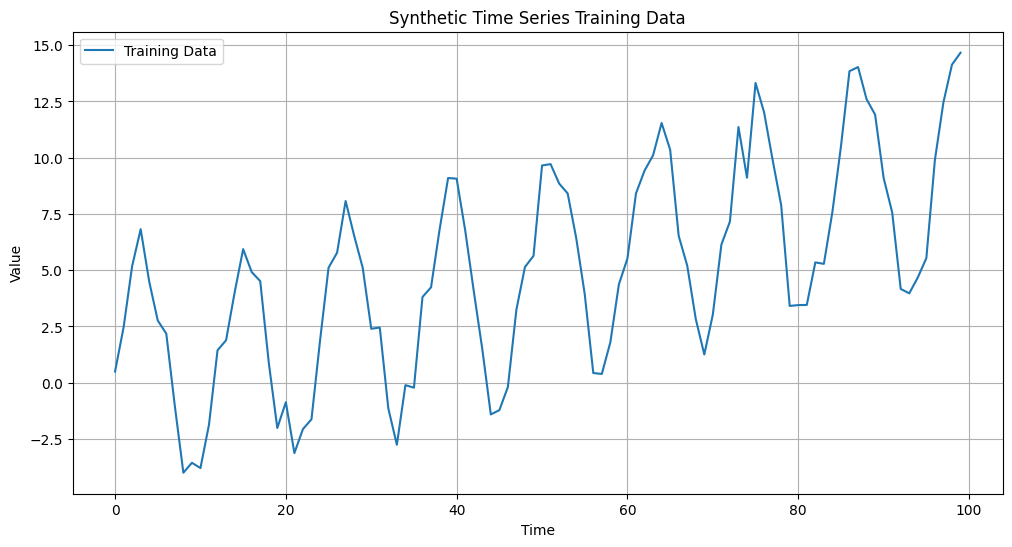

In [3]:
def generate_synthetic_data(n_points=100, trend_coef=0.1, season_amp=5, noise_std=1, seed=42):
    """Generate synthetic time series data with trend, seasonality, and noise."""
    np.random.seed(seed)
    time = np.arange(n_points)
    trend = trend_coef * time
    seasonality = season_amp * np.sin(2 * np.pi * time / 12)
    noise = np.random.normal(0, noise_std, n_points)
    data = trend + seasonality + noise
    
    return pd.DataFrame({
        'time': time,
        'value': data
    })

# Generate and visualize training data
train_df = generate_synthetic_data()
plt.plot(train_df['time'], train_df['value'], label='Training Data')
plt.title('Synthetic Time Series Training Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## 3. Prepare Features and Train Model

We'll create lagged features and train a linear regression model.

Model Performance:
Mean Squared Error: 4.29
R2 Score: 0.73


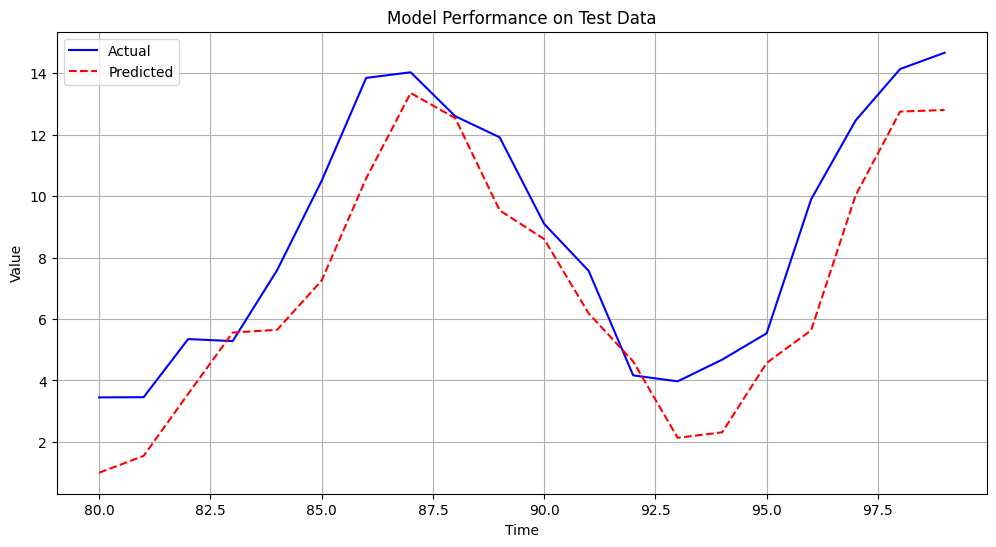

In [4]:
def prepare_features(df, n_lags=3):
    """Create lagged features for time series prediction."""
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = df['value'].shift(i)
    return df.dropna()

# Prepare features and split data
train_df = prepare_features(train_df)
X = train_df[['lag_1', 'lag_2', 'lag_3']]
y = train_df['value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train and evaluate model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Model Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")

# Visualize predictions
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Model Performance on Test Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## 4. Deploy Model to IBM Watson Machine Learning

We'll create a function to deploy the model and get the deployment details.

In [7]:
# WML credentials
wml_credentials = {
    "apikey": "VuP5yoxHgWdzOhILSPlWbw27fK5tNPzAwMAHh7j1DKyy",
    "url": "https://us-south.ml.cloud.ibm.com"
}
space_id = "5301a9bd-7f2b-439e-85e0-4f1138b75db6"
model_name='TimeSeriesPredictionModel'

# Initialize client
client = APIClient(wml_credentials)
client.set.default_space(space_id)

# Store model
software_spec_uid = client.software_specifications.get_uid_by_name("runtime-24.1-py3.11")
model_meta_props = {
    client.repository.ModelMetaNames.NAME: model_name,
    client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.3',
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
}

model_details = client.repository.store_model(model=model, meta_props=model_meta_props)
model_uid = client.repository.get_model_id(model_details)

# Create deployment
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: f"Deployment of {model_name}",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

deployment = client.deployments.create(model_uid, meta_props=metadata)
deployment_uid = client.deployments.get_id(deployment)
scoring_endpoint = client.deployments.get_scoring_href(deployment)
    

# Deploy model
print(f"Model deployed successfully!")
print(f"Deployment UID: {deployment_uid}")
print(f"Scoring endpoint: {scoring_endpoint}")



#######################################################################################

Synchronous deployment creation for uid: 'fa30a4cd-08e9-4461-bf4f-770071bcfb3a' started

#######################################################################################


initializing
Note: online_url and serving_urls are deprecated and will be removed in a future release. Use inference instead.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='572b45e2-5dcd-46c4-b93e-ec05c3acd7c7'
------------------------------------------------------------------------------------------------


Model deployed successfully!
Deployment UID: 572b45e2-5dcd-46c4-b93e-ec05c3acd7c7
Scoring endpoint: https://us-south.ml.cloud.ibm.com/ml/v4/deployments/572b45e2-5dcd-46c4-b93e-ec05c3acd7c7/predictions


## 5. Test Model on New Data

Let's generate new data and test our deployed model.

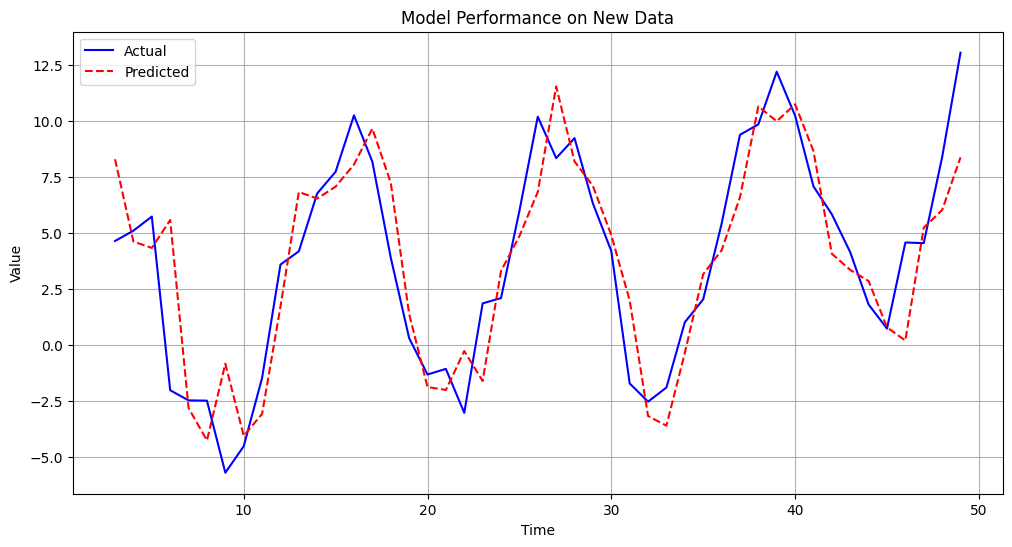


Performance on New Data:
Mean Squared Error: 5.77
R2 Score: 0.75


In [8]:
def predict_with_deployed_model(client, deployment_uid, features):
    """Make predictions using the deployed model."""
    scoring_payload = {
        "input_data": [{
            "values": [features.tolist()]
        }]
    }
    return client.deployments.score(deployment_uid, scoring_payload)

# Generate and test on new data
test_df = generate_synthetic_data(n_points=50, trend_coef=0.15, season_amp=6, noise_std=1.2, seed=123)
test_df = prepare_features(test_df)
X_new = test_df[['lag_1', 'lag_2', 'lag_3']].values

# Make predictions
predictions = []
for features in X_new:
    result = predict_with_deployed_model(client, deployment_uid, features)
    predictions.append(result['predictions'][0]['values'][0][0])

# Add predictions to DataFrame
test_df['predicted'] = np.nan
test_df.loc[3:, 'predicted'] = predictions

# Visualize results
plt.plot(test_df['time'], test_df['value'], label='Actual', color='blue')
plt.plot(test_df['time'], test_df['predicted'], label='Predicted', color='red', linestyle='--')
plt.title('Model Performance on New Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Calculate performance metrics
actual_values = test_df['value'].iloc[3:]
predicted_values = test_df['predicted'].iloc[3:]
mse = mean_squared_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)

print(f"\nPerformance on New Data:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")